In [1]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from scipy.stats import randint
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from src.features.build_features import MostFrequentImputer, load_data, add_bucket, set_title

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Load Data 

In [2]:
# train data 
train_data = load_data("train.csv")
y_train = train_data["Survived"]

# test data
test_data = load_data("test.csv")

# Transform data

## Add new columns

In [3]:
relatives = ['SibSp' ,'Parch']

def add_columns(df):
    df['family'] = df[relatives].sum(axis=1)
    df['traveling_alone'] = np.where(df['family']==0,1,0)
    df['Sex'] = np.where(df['Sex']=='female',0,1)
    df['Age_Bucket'] = add_bucket(df['Age'], bins=6)
    df['Fare_Bucket'] = add_bucket(df['Fare'], bins=6)
    df['Title'] = df['Name'].apply(set_title)
    df['name_length'] = df['Name'].apply(len)
    df['Cabin'] = df['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
    return df


train_data = add_columns(train_data)
test_data = add_columns(test_data)

Sex works better as category than converting to 0 and 1 

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family,traveling_alone,Age_Bucket,Fare_Bucket,Title,name_length
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S,1,0,1.0,0,Mr,23
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C,1,0,4.0,5,Mrs,51
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,0,1,2.0,1,Miss,22
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S,1,0,4.0,5,Mrs,44
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S,0,1,4.0,1,Mr,24


## Pipelines

In [5]:
# numerical pipeline
num_pipeline = Pipeline([ ("imputer", SimpleImputer(strategy="median")) ])

In [6]:
# categorical pipeline 
cat_pipeline = Pipeline([
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [7]:
# Full pipeline 
cat_attribs = ["Pclass", 'Embarked',  'Age_Bucket', 'Fare_Bucket', 'Title',]
num_attribs = [ "family", 'name_length',  'traveling_alone', 'Cabin', 'Sex', 'Age', 'Fare']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train = full_pipeline.fit_transform(train_data)
X_test = full_pipeline.transform(test_data)

# Find groupings with PCA and GMM 
Selected a few features to find a grouping. Forced PCA to separate data into two groups. Used GMM to predict the grouping. 

In [8]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

In [ ]:
X_train
X2 = PCA(2, svd_solver='full').fit_transform(X_train)

In [ ]:
gmm = GaussianMixture(2)
gmm.fit(X_train)
labels = gmm.predict(X_train)
plt.scatter(X2[:, 0], X2[:, 1], c = labels, cmap='rainbow', alpha=.5);
plt.colorbar();

In [ ]:
# add grouping to labels to 
X_train = np.c_[X_train, gmm.predict(X_train)]
X_test = np.c_[X_test, gmm.predict(X_test)]


# Test models

In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)

In [10]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto")

In [11]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [12]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(random_state=42, solver= 'liblinear' , penalty='l2')

In [13]:
ada_clf = AdaBoostClassifier()

In [14]:
xgb_clf = GradientBoostingClassifier(random_state=42)

In [15]:
models = [knn_clf, svm_clf,  log_clf, ada_clf, forest_clf, xgb_clf]
# train models
scores = []
for model in models:
    scores.append(cross_val_score(model, X_train, y_train, cv=10))

In [16]:
labels = ['KNN', 'SVM', 'Log Reg', 'Ada Boost', "Random Forest", 'Gradient Boosting']
mean_scores = [score.mean() for score in scores]
pd.DataFrame({'models': labels, 'scores':mean_scores}).set_index('models')

,scores
models,
KNN,0.717323
SVM,0.733053
Log Reg,0.813704
Ada Boost,0.809220
Random Forest,0.817075
Gradient Boosting,0.822730


## Plot the Classifiers scores 

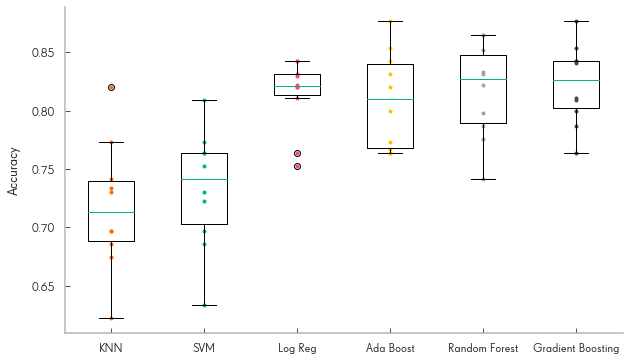

In [17]:
plt.figure(figsize=(10, 6))

# create scatter points 
for i, score in enumerate( scores, start=1): 
    plt.plot([i]*10, score, ".")

plt.boxplot(scores, labels=labels)
plt.ylabel("Accuracy", fontsize=14)
#plt.xlim(-.5,5.5)
#plt.ylim(.5,1)
plt.show()

# Tune xgboost  model 

In [ ]:
param_distribs = {
        'n_estimators': randint(low=1, high=500),
        'max_features': randint(low=1, high=10),
    }

rnd_search = RandomizedSearchCV(xgb_clf , param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

In [ ]:
# rename classifier 
xgb_clf = rnd_search.best_estimator_

## inspect hyperparameters

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print('score: \t {}  \t \t {}'.format(round(np.sqrt(-mean_score),4 ) , params))


In [ ]:
# retrieve categorical attribute names 
cat_attribs_encoded= list(full_pipeline.transformers_[1][1].named_steps["cat_encoder"].get_feature_names())
cat_attribs_encoded

In [ ]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
trained_columns = num_attribs + cat_attribs_encoded + ['group']
sorted(zip(feature_importances,trained_columns), reverse=True)

In [ ]:
xgb_clf.score(X_train, y_train)

In [ ]:
xgb_params = xgb_clf.get_params()

## Model metrics

### ROC curve 

In [ ]:
y_probas=xgb_clf.predict_proba(X_train)
y_scores = y_probas[:, 1] # score = proba of positive class

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()



In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_scores)

In [ ]:
y_train_pred = xgb_clf.predict(X_train)
precision_score(y_train, y_train_pred)

In [ ]:
recall_score(y_train, y_train_pred)

In [ ]:
# f1 score 
f1_score(y_train, y_train_pred)

### Precision recall curve

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "orange", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()
roc_auc_score(y_train, y_scores)

# Tune Log Reg model

In [ ]:
# Create hyperparameter options
hyperparameters ={'penalty': ['l2', 'l1'], 
                         'class_weight': [None, 'balanced'],
                         'C': np.logspace(-20, 20, 10000), 
                         'intercept_scaling': np.logspace(-20, 20, 10000)}
# Create randomized search 5-fold cross validation and 100 iterations
clf = RandomizedSearchCV(log_clf, hyperparameters, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=-1)
# Fit randomized search
log_model = clf.fit(X_train, y_train)

In [ ]:
# View best hyperparameters
print('Best Penalty:', log_model.best_estimator_.get_params()['penalty'])
print('Best C:', log_model.best_estimator_.get_params()['C'])

In [ ]:
log_model.score(X_train, y_train)

In [ ]:
y_probas=log_model.predict_proba(X_train)
y_scores = y_probas[:, 1] # score = proba of positive class

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

In [ ]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Create prediction file 

In [ ]:

test_data['Survived'] = xgb_clf.predict(X_test)
submission = test_data[['PassengerId', 'Survived']]
# save
submission.to_csv(path_or_buf = 'data/processed/submissions.csv', index=False)

# Results 

**xgboost**
- kaggle score: 0.75119
- score: 0.8619528619528619
- auc: 0.9257368527572727
- cat_attribs = ["Pclass", 'Embarked',  'Age_Bucket', 'Fare_Bucket', 'Title', 'Sex', 'traveling_alone', 'Cabin']
- num_attribs = [ "family", 'name_length']

**xgboost with cv=10**
- kaggle score:0.75598
- score: 0.8855218855218855
- auc: 0.9409878673611777
- cat_attribs = ["Pclass", 'Embarked',  'Age_Bucket', 'Fare_Bucket', 'Title', 'Sex', 'traveling_alone', 'Cabin']
- num_attribs = [ "family", 'name_length']

**xgboost**
- kaggle score 0.74641
- score: 0.8810325476992144
- auc: 0.9438612469242323
- cat_attribs = ["Pclass", 'Embarked',  'Age_Bucket', 'Fare_Bucket', 'Title', 'Sex', 'traveling_alone', 'Cabin']
- num_attribs = [ "family", 'name_length']


**xgboost**
- kaggle score 0.75598
- score: 0.9147025813692481
- auc: 0.9643051161601636
- cat_attribs = ["Pclass", 'Embarked',  'Age_Bucket', 'Fare_Bucket', 'Title',]
- num_attribs = [ "family", 'name_length',  'traveling_alone', 'Cabin', 'Sex', 'Age', 'Fare']